In [1]:
from requests import get
#!/usr/bin/env python3
"""
Return the number of *Running* pods in namespace `social-network`
that are scheduled on node `k8s-worker-1` at **2025-07-14 06:51:00** (AEST).

Adjust PROM_URL if your Prometheus endpoint is different.
"""
import datetime as dt
import requests
import urllib.parse
from zoneinfo import ZoneInfo   # Python ≥3.9

PROM_URL = "http://10.105.116.175:9090"          # ← change if needed

PROMQL = r"""
sum(
  (kube_pod_status_phase{namespace="social-network",phase="Running"} == 1)
    * on(pod,namespace) group_left(node)
      kube_pod_info{namespace="social-network",node="k8s-worker-1"}
)
"""

def get_node_running_pods_num(eval_time, nodeName=None, namespace="social-network"):
    """
    Get the number of running pods on each node at the specified evaluation time.
    
    :param eval_time: The time at which to evaluate the metrics.
    :param iterval: Interval in seconds for querying the metrics.
    :return: Dictionary with node names as keys and number of running pods as values.
    """
    if nodeName is None:
        nodeName = "k8s-worker-1"
    
    epoch_sec = int(eval_time.timestamp())
    
    promql = f"""
    sum(
      (kube_pod_status_phase{{namespace="{namespace}",phase="Running"}} == 1)
        * on(pod,namespace) group_left(node)
          kube_pod_info{{namespace="{namespace}",node="{nodeName}"}}
    )
    """
    
    resp = requests.get(
        f"{PROM_URL}/api/v1/query",
        params={
            "query": promql,
            "time": epoch_sec,
        },
        timeout=10,
    )
    resp.raise_for_status()
    payload = resp.json()
    print(payload)
    
    if payload["status"] != "success":
        raise RuntimeError(f"Prometheus error: {payload.get('error', payload)}")
    
    result = payload["data"]["result"]
    # nodeName = nodeName.replace("k8s-worker-", "k8s-worker-")  # Ensure consistent naming#
    # to draw a clen figure, replce "k8s-worker-" with "Node-"
    nodeName = nodeName.replace("k8s-worker-", "Node-")  # Ensure consistent naming for plotting
    if not result:
        return {nodeName: 0}  # No running pods found
    
    return {nodeName: float(result[0]["value"][1])}

# start_time = dt.datetime(2025, 7, 14, 12, 55, 0)
start_time = dt.datetime(2025, 7, 15, 6, 26, 0)

eval_interval = 8 # 8 mins

node_running_pods_num = {"k8s-worker-1":{},"k8s-worker-2":{},"k8s-worker-3":{},"k8s-worker-4":{},"k8s-worker-5":{},
             "k8s-worker-6":{},"k8s-worker-7":{},"k8s-worker-8":{},"k8s-worker-9":{},"k8s-worker-10":{},
             "k8s-worker-11":{},"k8s-worker-12":{},"k8s-worker-13":{},"k8s-worker-14":{},"k8s-worker-15":{}
}


for node in node_running_pods_num.keys():
    # add four evaluation points
    eval_timepoint1 = start_time + dt.timedelta(minutes=eval_interval)
    node_running_pods_num[node]["8"] = get_node_running_pods_num(eval_timepoint1, nodeName=node, namespace="social-network")
    eval_timepoint2 = start_time + dt.timedelta(minutes=eval_interval*2)
    node_running_pods_num[node]["16"] = get_node_running_pods_num(eval_timepoint2, nodeName=node, namespace="social-network")

    eval_timepoint3 = start_time + dt.timedelta(minutes=eval_interval*3)
    node_running_pods_num[node]["24"] = get_node_running_pods_num(eval_timepoint3, nodeName=node, namespace="social-network")
    eval_timepoint4 = start_time + dt.timedelta(minutes=eval_interval*4)
    node_running_pods_num[node]["32"] = get_node_running_pods_num(eval_timepoint4, nodeName=node, namespace="social-network")

    print(node)
    print(node_running_pods_num[node])
    print("\n")
    


{'status': 'success', 'data': {'resultType': 'vector', 'result': [{'metric': {}, 'value': [1752561240, '2']}]}}
{'status': 'success', 'data': {'resultType': 'vector', 'result': [{'metric': {}, 'value': [1752561720, '14']}]}}
{'status': 'success', 'data': {'resultType': 'vector', 'result': [{'metric': {}, 'value': [1752562200, '14']}]}}
{'status': 'success', 'data': {'resultType': 'vector', 'result': [{'metric': {}, 'value': [1752562680, '14']}]}}
k8s-worker-1
{'8': {'Node-1': 2.0}, '16': {'Node-1': 14.0}, '24': {'Node-1': 14.0}, '32': {'Node-1': 14.0}}


{'status': 'success', 'data': {'resultType': 'vector', 'result': []}}
{'status': 'success', 'data': {'resultType': 'vector', 'result': [{'metric': {}, 'value': [1752561720, '1']}]}}
{'status': 'success', 'data': {'resultType': 'vector', 'result': [{'metric': {}, 'value': [1752562200, '1']}]}}
{'status': 'success', 'data': {'resultType': 'vector', 'result': [{'metric': {}, 'value': [1752562680, '1']}]}}
k8s-worker-2
{'8': {'Node-2': 0},

['k8s-worker-1', 'k8s-worker-2', 'k8s-worker-3', 'k8s-worker-4', 'k8s-worker-5', 'k8s-worker-6', 'k8s-worker-7', 'k8s-worker-8', 'k8s-worker-9', 'k8s-worker-10', 'k8s-worker-11', 'k8s-worker-12', 'k8s-worker-13', 'k8s-worker-14', 'k8s-worker-15']


/tmp/ipykernel_1333030/1602586245.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(y)}' for y in ax.get_yticks()], fontsize=14)


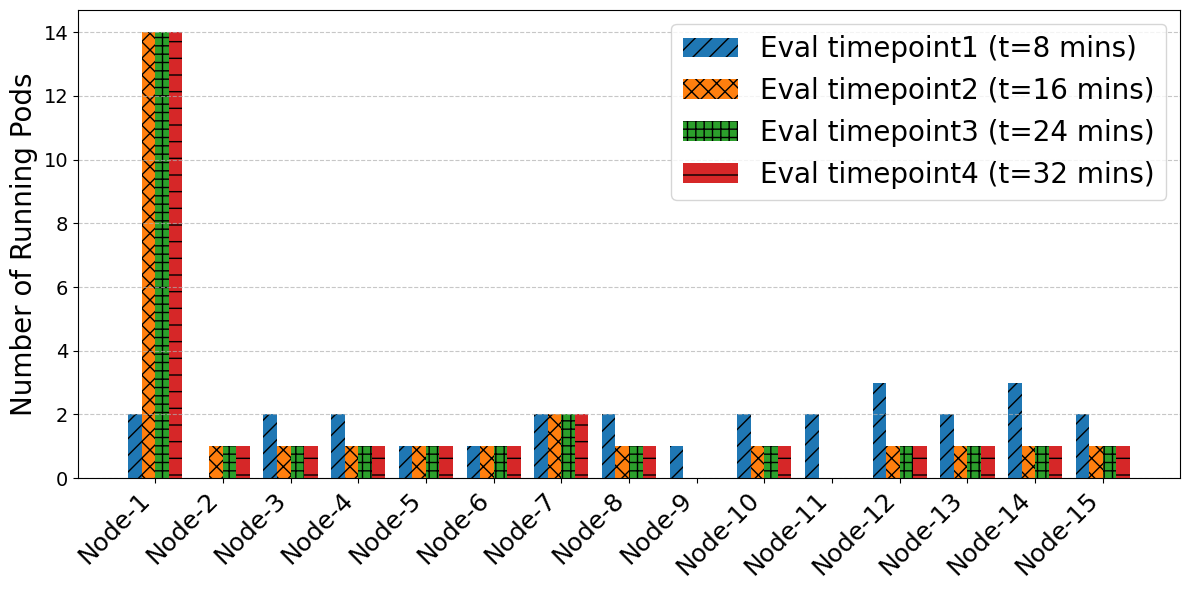

In [2]:
import matplotlib.pyplot as plt
import numpy as np
node_labels = list(node_running_pods_num.keys())  # Replace "k8s-worker-" with "Node-" for plotting
print (node_labels)
# node_labels = [node.replace("k8s-worker-", "Node-") for node
#                in node_running_pods_num.keys()]  # Replace "k8s-worker-" with "Node-" for plotting


# Extract the pod counts (float) from the nested dicts, defaulting to np.nan if missing
eval_points = ["8", "16", "24", "32"]
running_pods_counts = [
    [
        list(node_running_pods_num[node][pt].values())[0] if node_running_pods_num[node][pt] else np.nan
        for pt in eval_points
    ]
    for node in node_labels
]
x = np.arange(len(node_labels))  # the label locations
width = 0.2  # the width of the bars
bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each eval point
bar_hatches = ['//', 'xx', '++', '-'] # Different line styles for each eval point
fig, ax = plt.subplots(figsize=(12, 6))
bars = []
for i in range(len(eval_points)):
    bar = ax.bar(
        x + i * width,
        [counts[i] for counts in running_pods_counts],
        width,
        color=bar_colors[i],
        label=f'Eval timepoint{i+1} (t={eval_points[i]} mins)'
    )
    # Add hatch style to each bar in this group
    for rect in bar:
        rect.set_hatch(bar_hatches[i])
    bars.append(bar)

# ax.set_xlabel('Cluster Nodes', fontsize=18)
ax.set_ylabel('Number of Running Pods', fontsize=20)
# ax.set_title('Number of Running Pods on Each Node Over Time')
ax.set_xticks(x + width * (len(eval_points) - 1) / 2)

# Replace "k8s-worker-" with "Node-" for plotting
trim_node_labels = [node.replace("k8s-worker-", "Node-") for node
               in node_running_pods_num.keys()]  

ax.set_xticklabels(trim_node_labels, fontsize=18, rotation=45, ha='right')
# set the number on y-axis as fontsize 14
ax.set_yticklabels([f'{int(y)}' for y in ax.get_yticks()], fontsize=14)
# set y-axis ticks to be integer

# set x albels with 45 degree rotation
# plt.xticks(rotation=45)
ax.legend(fontsize='20', loc='upper right')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('k8s_running_pods_plot1_2.png')
plt.show()
# --- END IGNORE ---

['k8s-worker-1', 'k8s-worker-2', 'k8s-worker-3', 'k8s-worker-4', 'k8s-worker-5', 'k8s-worker-6', 'k8s-worker-7', 'k8s-worker-8', 'k8s-worker-9', 'k8s-worker-10', 'k8s-worker-11', 'k8s-worker-12', 'k8s-worker-13', 'k8s-worker-14', 'k8s-worker-15']


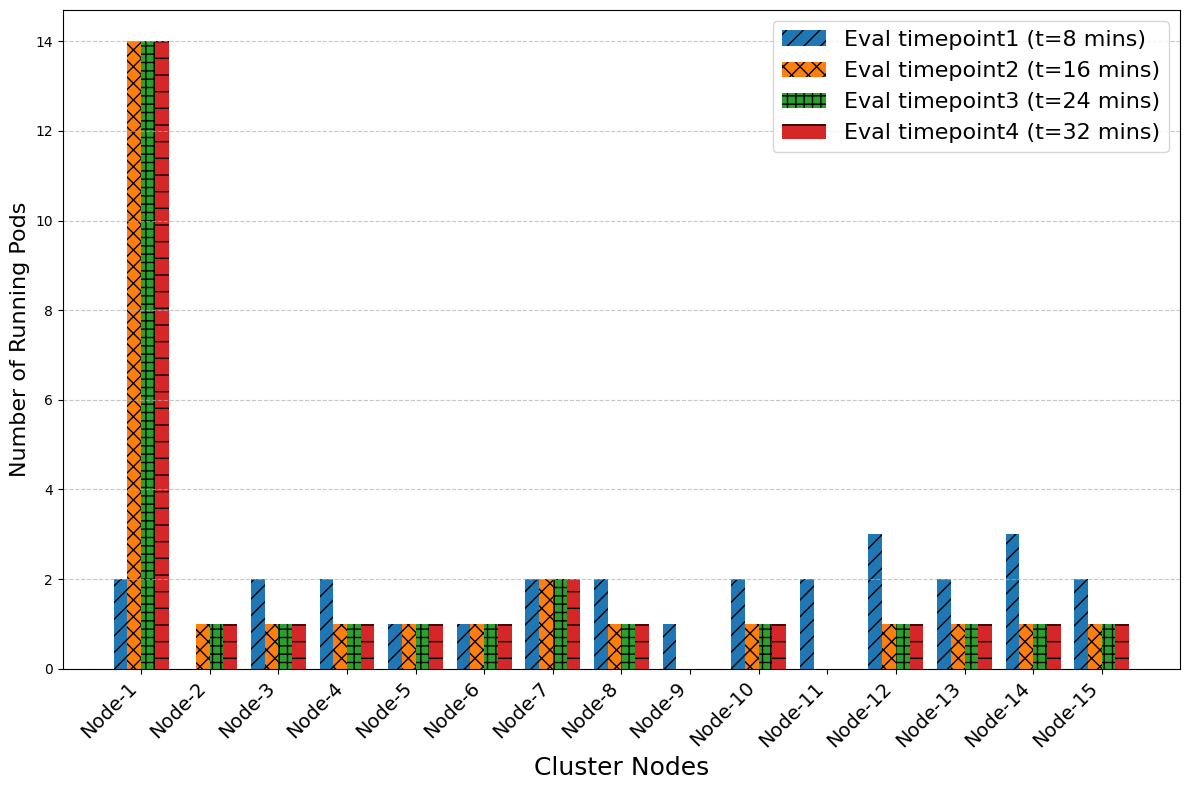

In [2]:
# Plot an aggreagted figure (with x-axis as node labels, and y as the number of running pods)
# the figure includes 15 different nodes, each with 4 evaluation points(8, 16, 24, 32), which means 0~ 32 mins
# the x-axis is the node labels, and the y-axis is the number of running pods
# the figure is saved as a png file in the current directory
import matplotlib.pyplot as plt
import numpy as np
node_labels = list(node_running_pods_num.keys())  # Replace "k8s-worker-" with "Node-" for plotting
print (node_labels)
# node_labels = [node.replace("k8s-worker-", "Node-") for node
#                in node_running_pods_num.keys()]  # Replace "k8s-worker-" with "Node-" for plotting


# Extract the pod counts (float) from the nested dicts, defaulting to np.nan if missing
eval_points = ["8", "16", "24", "32"]
running_pods_counts = [
    [
        list(node_running_pods_num[node][pt].values())[0] if node_running_pods_num[node][pt] else np.nan
        for pt in eval_points
    ]
    for node in node_labels
]
x = np.arange(len(node_labels))  # the label locations
width = 0.2  # the width of the bars
bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each eval point
bar_hatches = ['//', 'xx', '++', '-'] # Different line styles for each eval point
fig, ax = plt.subplots(figsize=(12, 8))
bars = []
for i in range(len(eval_points)):
    bar = ax.bar(
        x + i * width,
        [counts[i] for counts in running_pods_counts],
        width,
        color=bar_colors[i],
        label=f'Eval timepoint{i+1} (t={eval_points[i]} mins)'
    )
    # Add hatch style to each bar in this group
    for rect in bar:
        rect.set_hatch(bar_hatches[i])
    bars.append(bar)

ax.set_xlabel('Cluster Nodes', fontsize=18)
ax.set_ylabel('Number of Running Pods', fontsize=16)
# ax.set_title('Number of Running Pods on Each Node Over Time')
ax.set_xticks(x + width * (len(eval_points) - 1) / 2)

# Replace "k8s-worker-" with "Node-" for plotting
trim_node_labels = [node.replace("k8s-worker-", "Node-") for node
               in node_running_pods_num.keys()]  

ax.set_xticklabels(trim_node_labels, fontsize=14, rotation=45, ha='right')
# set x albels with 45 degree rotation
# plt.xticks(rotation=45)
ax.legend(fontsize='16', loc='upper right')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('k8s_running_pods_plot1.png')
plt.show()
# --- END IGNORE ---

In [3]:
#!/usr/bin/env python3
"""
Return the number of *Running* pods in namespace `social-network`
that are scheduled on node `k8s-worker-1` at **2025-07-14 06:51:00** (AEST).

Adjust PROM_URL if your Prometheus endpoint is different.
"""
import datetime as dt
import requests
import urllib.parse
from zoneinfo import ZoneInfo   # Python ≥3.9

PROM_URL = "http://10.105.116.175:9090"          # ← change if needed

PROMQL = r"""
sum(
  (kube_pod_status_phase{namespace="social-network",phase="Running"} == 1)
    * on(pod,namespace) group_left(node)
      kube_pod_info{namespace="social-network",node="k8s-worker-13"}
)
"""

eval_time = dt.datetime(2025, 7, 15, 6, 26, 0)
epoch_sec = int(eval_time.timestamp())           # Prometheus expects UTC epoch

# ── call Prometheus instant-query API ────────────────────────────
resp = requests.get(
    f"{PROM_URL}/api/v1/query",
    params={
        "query": PROMQL,
        "time": epoch_sec,                       # evaluate at the exact instant
    },
    timeout=10,
)
resp.raise_for_status()
payload = resp.json()

if payload["status"] != "success":
    raise RuntimeError(f"Prometheus error: {payload.get('error', payload)}")

result = payload["data"]["result"]
if not result:
    print("No data returned (check metric names / labels).")
else:
    pod_count = float(result[0]["value"][1])
    print(f"Running social-network pods on k8s-worker-1 at {eval_time}: {pod_count:g}")



Running social-network pods on k8s-worker-1 at 2025-07-15 06:26:00: 2
